# Core Concepts Behind Personal LLM - Alessio Naji-Sepasgozar

This note is a high-level conceptual map of what we've built so far. No code — just ideas, math in words, and why it matters.

---

## 1. Language Modeling (Next-Token Prediction)

Our model is a **causal language model**. Its job is simple but powerful:

> Given a sequence of tokens so far, predict the most likely next token.

Example:
- Input so far: "I need to go to the"
- Model predicts: "gym", "store", "hospital", etc.
- It assigns probabilities to each choice.

During training:
- We show the model real sequences and tell it what the *correct* next token was.
- It adjusts itself to get better at that prediction next time.

This looks like "autocomplete," but scaled up, this is how the model learns grammar, reasoning structure, planning behavior, tone — everything.

---

## 2. Tokens and Embeddings

Text (words, subwords, punctuation) gets turned into integers called **tokens**.

Example:
- `"hello"` → 913
- `"world"` → 5521
- `"!"` → 42

The model doesn’t work directly on words. It works on these integers.

But integers alone are meaningless. So for each token ID, we learn a vector (a list of numbers). That vector is called an **embedding**.

- Think of an embedding as: "the numeric meaning of this token in this context space."

If `d_model = 256`, that means every token is represented as a 256-dimensional learned vector.

We also add **positional embeddings**: a learned vector for position 0, 1, 2, ... in the sequence. This tells the model word order.  
So the model knows "this token is at the start of the sentence" vs "this token is near the end."

---

## 3. Transformer Blocks

A Transformer block is the main building unit in modern LLMs. We stack many of them.

Each block does two big things, for every token position in the sequence:

1. **Self-Attention**  
   "Look at the previous tokens, decide which ones are relevant to me right now, and pull information from them."

2. **Feedforward Network (MLP)**  
   "Take my current state and nonlinearly transform it to refine meaning."

Each block also uses:
- **LayerNorm** to stabilize activations
- **Residual connections** so we don't forget what we had before

You can think of each Transformer block as:
> "Update my understanding of what's going on, based on the whole context so far."

When we stack 8 of these blocks, each token's internal representation becomes incredibly rich — it's no longer "just the word", it's "the word in this situation, with everything that's happened so far, and what matters."

---

## 4. Self-Attention (Causal Self-Attention)

Self-attention is how the model learns relationships between tokens.

For each token position `t`, the model asks:
> "Which earlier tokens should I pay attention to in order to understand what I should say next?"

It does this using three learned vectors for each token:
- **Query (Q):** What I'm looking for
- **Key (K):** What I contain
- **Value (V):** The information I can give you if you care about me

Math idea in words:
1. For the current token, compare its Query to every previous token's Key.
2. The better the match, the more that previous token matters.
3. Use those matches to take a weighted blend of those previous tokens' Value vectors.
4. That blended result becomes "what I know now, thanks to context."

So attention is literally:
- "Who should I listen to?"
- "How much?"
- "What do I take from them?"

### Why "causal"?

We only allow a token at position `t` to look at positions ≤ `t`.  
This prevents the model from "cheating" and looking at future tokens during training.  
That matches how we generate text: left to right.

This masking is what makes it a *causal* language model.

---

## 5. Multi-Head Attention

We don't just do attention once — we do it in parallel with multiple "heads."

Each head:
- Looks at the same sequence,
- But can specialize in different kinds of relationships.

For example:
- One head might learn "who is the subject of this sentence?"
- Another might track tense or time.
- Another might track emotional tone.

All heads produce their own contextual understanding. Then we combine them back together.

You can think of multi-head attention as:
> Several tiny analysts, each looking for different patterns in what you've said so far, then pooling their insights.

---

## 6. Feedforward Network (Inside Each Block)

After attention blends information across tokens, we apply a small neural network (an MLP) to each token independently.

Why?  
Attention tells me "what matters from the past."  
The feedforward network says "given that, transform me into a better internal state."

This MLP is nonlinear. That’s important. Nonlinearity lets the model build concepts like:
- "This sounds urgent"
- "This is a plan"
- "This is you talking about money, which you care about"

It's not just averaging; it's *understanding structure*.

---

## 7. Residual Connections and LayerNorm

Each sub-part of the block (attention, feedforward) is wrapped like this:

- Normalize the input (LayerNorm),
- Apply the sub-layer,
- Add the result back to the original ("residual connection").

Why residual?
- It lets the model say "just keep what I already know, plus a small correction."
- This makes deep networks (many stacked blocks) trainable and stable.

Why LayerNorm?
- It keeps values in a reasonable range so learning doesn't blow up.

Think of it like:
> "Before I think, calm down. After I think, don't throw away who I am, just refine me."

---

## 8. The LM Head (Final Prediction Layer)

After all the Transformer blocks, the final hidden state of each token position is a vector of size `d_model`.

We then apply one last linear layer that turns that vector into a score for every token in the vocabulary.

So for each position, we get:
- A score for token 0
- A score for token 1
- ...
- A score for token 15,999

These raw scores are called **logits**.

From logits, we can get probabilities using **softmax**.

---

## 9. Softmax (Turning Scores Into Probabilities)

Softmax takes a list of raw scores (logits) and turns them into a probability distribution.

In words:
- Subtract the largest score (for stability),
- Exponentiate all the scores,
- Divide each exponentiated score by the sum of all exponentiated scores.

Effect:
- Larger logits → higher probability
- All probabilities are positive
- All probabilities sum to 1

This lets us say: "Given all possible next tokens, here’s how likely each one is."

When we **generate text**:
- We look at the last position’s logits,
- Use softmax to get probabilities,
- Pick one token (greedy: pick the highest probability, or later we can sample).

Softmax is how "scores" turn into "model believes this is the next word."

---

## 10. Training Objective (Cross-Entropy Loss)

How do we train the model?

We do this:
1. Feed in a sequence of tokens.
2. Ask the model to predict the *next* token at each position.
   - Position 0 tries to predict the token at position 1.
   - Position 1 tries to predict the token at position 2.
   - etc.
3. Compare the model's predicted probability distribution to the true token.

This comparison uses **cross-entropy loss**.

Conceptually:
- If the model said "the next token is probably 'pizza'" but actually the next token was "rent", the loss is high.
- If the model assigns high probability to the correct next token, the loss is low.

The model then adjusts its weights to reduce that loss.

In plain language:
> Training is just punishing the model every time it guesses the next token wrong.

Do this millions of times and it learns language, structure, your style, your priorities.

---

## 11. Autoregressive Generation

At inference time (chat mode):
1. You give the model a starting prompt ("I feel stressed about...").
2. The model predicts the next token.
3. You append that token.
4. Now you have a slightly longer prompt.
5. You feed the longer prompt back in and predict the next token again.
6. Repeat.

This is called **autoregressive generation**:
- "auto" = by itself,
- "regressive" = step by step based on previous output.

The key point: the model is always generating one token at a time into the future, never editing the past.

---

## 12. Why This Architecture Works for a Personal Assistant

Why is this setup (Transformer + causal attention + next-token training) so good for a personal life assistant?

- It naturally models *continuation of thought*.  
  You give it context (your mood, your plans, your goals), it continues in your voice.

- Attention lets it pull in relevant context even from many tokens back.  
  "Oh, they mentioned debt 100 tokens ago — bring that back."

- Because we train on your writing, it learns your tone, not just English.

- Because it’s causal, it can run locally and answer you in real time just by stepping forward, one token at a time. No fancy future planning required — it's literally just thinking "what would I say next?"

That’s the same core principle behind large commercial LLMs. We're just building a smaller, personally aligned one.

---


In [1]:
import torch
import numpy as np

from model.model_config import ModelConfig
from model.model import Transformer
from model.utils import count_parameters

print("Torch version:", torch.__version__)
print("NumPy version:", np.__version__)

config = ModelConfig()
model = Transformer(config)

print("Param count:", count_parameters(model))

# Fake batch of token IDs (batch=2, seq_len=16)
dummy = torch.randint(0, config.vocab_size, (2, 16))
logits, loss = model(dummy, dummy)

print("logits shape:", logits.shape)  # expect (2, 16, vocab_size)
print("loss:", loss.item())           # expect around ~9-11 untrained

# Quick generation test
start_tokens = torch.randint(0, config.vocab_size, (1, 8))
generated = model.generate(start_tokens, max_new_tokens=10)

print("generated shape:", generated.shape)  # expect (1, 18)
print("generated token IDs:", generated)


Torch version: 2.7.1+cpu
NumPy version: 1.22.0
Param count: 14633472
logits shape: torch.Size([2, 16, 16000])
loss: 9.809053421020508
generated shape: torch.Size([1, 18])
generated token IDs: tensor([[ 9855,  8863, 10463, 11611,  2730,  8833,  9846,  4912,  7879, 15964,
         14705,  6913, 11939,  6873, 14746, 10962,  6406, 15249]])


## GOAL STEP 2

*Prove the model can learn at all.*

Watch the loss go down in real time.

Understand what each step of training is doing.

In [2]:
import torch
import torch.optim as optim

from model.model_config import ModelConfig
from model.model import Transformer

#Fresh model
config = ModelConfig
model = Transformer(config)

device = torch.device("cpu")
model = model.to(device)

# adam optimizer
optimizer = optim.AdamW(model.parameters(), lr = 1e-3)



# We’ll just generate random integer token sequences as “training data.” Think of them like nonsense sentences in a nonsense language. The model will try to predict the next token in these sequences.

In [3]:
def get_batch(batch_size=4, seq_len = 32, vocab_size = 16000, device = "cpu"):
    """
    Returns:
    - x: (batch_size, seq_len) input tokens
    - y: (batch_size, seq_len) target tokens (same sequence)
    
    Right now x and y are identical random ints. During real training:
    - x will be your text chunk
    - y will be that same chunk, shifted by 1 for next-token prediction
    """
    x = torch.randint(0, vocab_size, (batch_size, seq_len), device = device)
    y = x.clone()
    return x, y
    
# quick smoke test
xb, yb = get_batch(device=device, vocab_size=config.vocab_size)
print("batch shapes:", xb.shape, yb.shape)


batch shapes: torch.Size([4, 32]) torch.Size([4, 32])


In [4]:
# Training loop

loss_history = []

model.train()

for step in range(200):
    xb, yb = get_batch(
        batch_size=4,
        seq_len = 32,
        vocab_size = config.vocab_size,
        device = device
    )

    # Forward Pass 

    logits, loss = model(xb, yb)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if step % 20 == 0:
        print(f"step {step:03d} | loss = {loss.item():.4f}")

step 000 | loss = 9.8946
step 020 | loss = 9.8911
step 040 | loss = 9.8588
step 060 | loss = 9.7964
step 080 | loss = 9.8392
step 100 | loss = 9.8992
step 120 | loss = 9.8350
step 140 | loss = 9.9185
step 160 | loss = 9.9064
step 180 | loss = 9.8397


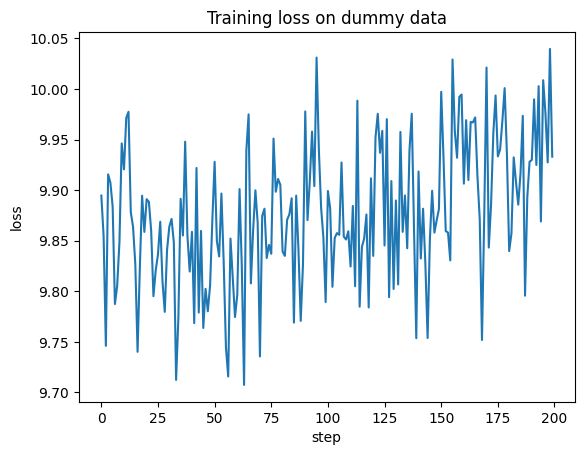

In [5]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel("step")
plt.ylabel("loss")
plt.title("Training loss on dummy data")
plt.show()


### What this loop does, conceptually:

model.train()
tells PyTorch “we’re training, not doing inference,” which activates dropout.

For each training step:

We sample random tokens (xb).

We ask the model to predict the next token at every position and calculate the cross-entropy loss.

We run loss.backward().
This computes gradients: how much each weight contributed to being wrong.

We call optimizer.step().
This nudges all weights in the direction that should reduce future loss.

We log the loss over time so we can see if it’s trending down.

Even though the data is random, the model will still usually find trivial statistical structure like “try to copy the previous token” because y == x. So the loss should generally come down from ~10 toward something lower.

## Next, we do:

*Build a tokenizer trained on text.*

*Use that tokenizer to convert text → token IDs → batches.*

*Feed those batches to your model and actually train it as a language model.*

# Tokenizer (critical for quality)

A model does not operate on words. It operates on integers ("token IDs").
Those IDs come from the tokenizer. The tokenizer defines your vocabulary.

A good tokenizer:

- compresses text efficiently

- handles weird slang / names

- doesn't explode uncommon words into 20 tiny fragments

A bad tokenizer:

- wastes context window on junk

- makes it impossible to learn certain styles

- kills model quality

We’re going to train a SentencePiece tokenizer (unigram or BPE style) on:

general English text

My own writing (journals, DMs, notes to self)

Because we want the tokenizer to natively represent “you words,” not just generic Wikipedia words. If you say things like “fr?”, “nahhh”, “gymcheck”, we want those to become single tokens if they show up enough.

## Target tokenizer settings

    vocab_size = 16000 (must match config.vocab_size)

    character coverage ~0.9995 (handles punctuation/emojis without blowing up vocab)

    treat the data as plain text, no special labels yet

## Workflow for tokenizer

### Do this once before training:

- Gather training text into a single file like:
data/corpus_raw.txt

This should include:

- some clean public English (Wikipedia subset, news, blog posts, etc.)

- your own notes / thoughts / reflections / plans / messages
(the more of “you,” the more it will talk like you later)

### Train the tokenizer on that file using SentencePiece and save:

tokenizer.model

tokenizer.vocab

Write helper functions:

encode(text) -> List[int]

decode(List[int]) -> text

Use encode to turn your corpus into a long list of token IDs and then build batches from that.

# 3. Next steps (concrete)

We’re going to do 4 steps:

Train a tokenizer on Stage 1 corpus.

Encode that corpus into token IDs.

Build a batcher that feeds those IDs into the model.

Run a real training loop.

In [ ]:
import sentencepiece as spm 
import os 

inputfile = "data/WikiCorpus.txt"
model_prefix = "tokenizer/spm"
vocab_size = 16000

spm.SentencePieceTrainer.Train(
    input = inputfile,
    model_prefix = model_prefix,
    vocab_size=vocab_size,
    character_coverage=0.995,
    model_type = "unigram",
    unk_id = 0,
    pad_id = 1,
    bos_id = 2,
    eos_id = 3
)
print("Tokenizer trained and saved a model to tokenizer/spm.model and tokenizer/spm.vocab")

In [6]:
import sentencepiece as spm
class SPTokenizer:
    def __init__(self, model_path: str):
        self.sp = spm.SentencePieceProcessor()
        self.sp.load(model_path)

    def encode(self, text: str) -> torch.Tensor:
        # list of token ids
        ids = self.sp.encode(text, out_type = int)
        return torch.tensor(ids, dtype=torch.long)

    def decode(self, ids: list[int]):
        if isinstance(ids, torch.Tensor):
            ids = ids.tolist()
        return self.sp.decode(ids)

In [7]:

tok = SPTokenizer("tokenizer/spm.model")

sample = "i need to get my life together fr this time."
ids = tok.encode(sample)

print("Text:", sample)
print("Token IDs:", ids)
print("Decoded back:", tok.decode(ids))


Text: i need to get my life together fr this time.
Token IDs: tensor([   6,   69, 1217,   14,  390, 2457,  378,  573,    6, 4943,   78,  101,
           4])
Decoded back: i need to get my life together fr this time.


In [8]:
vocab_path = "tokenizer/spm.vocab"

In [9]:
with open(vocab_path, "r", encoding = "utf-8") as f:
    lines = f.readlines()

for i, line in enumerate(lines[:50]):
    print(f"{i:4d} {line.strip()}")

   0 <unk>	0
   1 <pad>	0
   2 <s>	0
   3 </s>	0
   4 .	-3.14853
   5 ▁the	-3.21911
   6 ▁	-3.30991
   7 ,	-3.43895
   8 s	-3.6998
   9 ▁of	-3.79474
  10 ▁in	-3.91843
  11 ▁and	-4.02595
  12 ▁a	-4.12346
  13 ▁is	-4.31468
  14 ▁to	-4.42858
  15 ▁was	-4.5417
  16 ▁The	-4.86263
  17 ▁"	-4.94026
  18 -	-4.98645
  19 "	-5.24034
  20 ▁for	-5.24299
  21 ▁(	-5.26213
  22 ▁on	-5.30346
  23 '	-5.42055
  24 ▁by	-5.47102
  25 ▁It	-5.48472
  26 ▁He	-5.50228
  27 ▁as	-5.528
  28 ▁from	-5.5786
  29 ▁that	-5.60041
  30 ▁are	-5.6427
  31 ▁with	-5.6461
  32 )	-5.70867
  33 ▁In	-5.80929
  34 ▁an	-5.81487
  35 ▁at	-5.81568
  36 ing	-5.92097
  37 ▁his	-5.97043
  38 ▁it	-6.00128
  39 ▁he	-6.00995
  40 ▁or	-6.11246
  41 ed	-6.11837
  42 e	-6.12509
  43 ▁also	-6.15659
  44 ▁were	-6.17818
  45 ▁has	-6.18743
  46 ▁be	-6.21947
  47 ▁A	-6.31955
  48 a	-6.34699
  49 d	-6.34735


## We can quantify: “How many tokens does it take to express a sentence in my voice?”

Shorter = better. Fewer tokens per sentence = more you can fit into the 256-token context window. 

In [10]:
samples = [
    "i'm honestly tired of repeating the same cycle every monday",
    "i will wake up, lift, eat right, stop scrolling, and actually execute.",
    "bro i SWEAR this is the last time i'm resetting",
    "On god im bout to crash out"
]

for text in samples:
    ids = tok.encode(text)
    print("TEXT:", text)
    print("NUM TOKENS:", len(ids))
    print("IDS:", ids)
    print("---")


TEXT: i'm honestly tired of repeating the same cycle every monday
NUM TOKENS: 17
IDS: tensor([    6,    69,    23,   126, 15499,    79, 12658,     9,  9043,    36,
            5,   211,  4000,   683,     6,   809,  1320])
---
TEXT: i will wake up, lift, eat right, stop scrolling, and actually execute.
NUM TOKENS: 19
IDS: tensor([    6,    69,   197, 11417,   129,     7,  6736,     7,  1347,   708,
            7,  1233, 15744,    36,     7,    11,  2575, 15210,     4])
---
TEXT: bro i SWEAR this is the last time i'm resetting
NUM TOKENS: 20
IDS: tensor([   6, 2630,    6,   69,  109,  417,  395, 4905,   78,   13,    5,  409,
         101,    6,   69,   23,  126,  158,  406, 4600])
---
TEXT: On god im bout to crash out
NUM TOKENS: 8
IDS: tensor([ 122, 2733, 4209, 3004,  923,   14, 3627,  156])
---


In [ ]:
import torch 
tok = SPTokenizer("tokenizer/spm.model")
with open("data/WikiCorpus.txt", "r", encoding="utf-8") as f:
    text = f.read()

ids = tok.encode(text)
print ("Token Count: ", ids.shape)

torch.save(ids, "data/corpus_ids1.pt")
print("Saved -> data/corpus_ids.pt")

# 1. Stage 1 done

Have now:

A working Transformer architecture (Transformer class).

A trained tokenizer (tokenizer/spm.model).

A dataset of token IDs from a general English corpus (data/corpus_ids.pt).

A training loop that:

feeds real language data into model

computes next-token prediction loss

backprops with AdamW

updates weights

A saved checkpoint of the model after training.

This is the same core recipe actual LLMs use at scale:

Pretrain on a general corpus to learn language structure,

Save weights.

You did it locally, on CPU, with your own code.

That checkpoint is now your “base model.”

From now on, we do not start from random anymore. We load that checkpoint and continue training. That’s how you get smarter specialized versions.

# Why Stage 1 matters


Grammar and sentence flow.

Distributional semantics (which words tend to follow which words).

Explanatory structure (included Wikipedia-like text).

Some ability to generate coherent paragraphs rather than pure noise.

Some factual rhythm, even if the facts themselves might still be weak.

Before Stage 1, generation was basically random token IDs glued together.
After Stage 1, generation should start feeling like "English-ish," even if it's clumsy, repetitive, or shallow.

This is the “language brain.”

This is exactly why we don’t jump straight into “train on my journal first.” Your journal alone is not enough to teach English to a randomly initialized model. Stage 1 solved that for you.

# This cell cell does 3 things:

trains,

records every step’s loss into loss_history,

saves the checkpoint of the pretrained model.

In [ ]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

from model.model_config import ModelConfig
from model.model import Transformer
from model.utils import count_parameters

# Load tokenized corpus
ids = torch.load("data/corpus_ids1.pt")

device = torch.device("cpu")

config = ModelConfig(
    vocab_size=16000,
    n_layers=8,
    n_heads=8,
    d_model=256,
    d_ff=1024,
    context_window=512,
    dropout_rate=0.1,
)

model = Transformer(config).to(device)
print("Params:", count_parameters(model))

optimizer = optim.AdamW(
    model.parameters(),
    lr=3e-4,
    weight_decay=0.01,
)

num_epochs   = 3
seq_len      = 256
batch_size   = 8

loss_history = []
model.train()

def make_batch_stream(id_tensor: torch.Tensor, seq_len: int, batch_size: int, device: torch.device):
    total_tokens = id_tensor.size(0)
    num_seq = total_tokens // seq_len
    trimmed = id_tensor[: num_seq * seq_len]
    data = trimmed.view(num_seq, seq_len)
    indices = torch.randperm(num_seq)

    for i in range (0, num_seq, batch_size):
        batch_idx = indices[i:i+batch_size]
        x = data[batch_idx].to(device)
        y = x.clone()
        yield x, y
        
for epoch in range(num_epochs):
    batch_iter = make_batch_stream(
        id_tensor=ids,
        seq_len=seq_len,
        batch_size=batch_size,
        device=device,
    )
    for step, (xb, yb) in enumerate(batch_iter):
        logits, loss = model(xb, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

        if step % 50 == 0:
            print (f"epoch {epoch} step {step} | loss = {loss.item():4f}")
    print(f"[epoch {epoch}] last loss: {loss.item():4f}")

import os
os.makedirs("checkpoints", exist_ok=True)
torch.save(model.state_dict(), "checkpoints/stage1_general_pretrain.pt")
print("Saved -> checkpoints/stage1_general_pretrain.pt")

Params: 14633472
epoch 0 step 0 | loss = 9.879588
